# Analysis of US Coastguard GPS disruption data

## Prerequisites

In [3]:
import pandas as pd
from datetime import datetime as dt

In [4]:
%pip install lxml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 50.1 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Webscrape
Run this to webscrape the data to files. If you already have the data locally, skip this section.

### Web scrape GPS interruptions

In [2]:
table_list = pd.read_html(r'https://navcen.uscg.gov/gps-problem-report-status')
table_list[0].to_csv('gps_navcen.csv',index=False)

### Web scrape wikipedia 
#### US state codes

In [2]:
table_list_iso3166= pd.read_html('https://en.wikipedia.org/wiki/ISO_3166-2:US')

In [4]:
US_states_iso3166=table_list_iso3166[0]
US_states_iso3166['clean_state']=US_states_iso3166['Code'].apply(lambda x: x.split('-')[1])
US_states_iso3166.to_csv('US_states_iso3166.csv',index=False)

#### List of sovereign states

In [8]:
sovereign_states_list= pd.read_html('https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2')[2]
sovereign_states_list[sovereign_states_list['Country name (using title case)'].notna()].to_csv('sovereign_states.csv',index=False)

## Processing and Analysis

### Load from csv files

In [98]:
gps_disruption_df=pd.read_csv('gps_navcen.csv')
two_letter_codes=pd.read_csv('US_states_iso3166.csv')
sovereign_states=pd.read_csv('sovereign_states.csv')


In [99]:
gps_disruption_df['User']=gps_disruption_df['Description'].apply(lambda x: x.split('NAVCEN')[0])
gps_disruption_df['NAVCEN']=gps_disruption_df['Description'].apply(lambda x: x.split('NAVCEN')[1] if len(x.split('NAVCEN'))>1 else '')

In [100]:
gps_disruption_df

,Disruption Date/Time,Location,Type,Description,Cause,Closed Date,User,NAVCEN
0,10/16/2022 14:13:00 CST,Independence,Automobile,USER: My mapping services are constantly searc...,Mapping Issue,10/25/2022,USER: My mapping services are constantly searc...,sent data mapping information.
1,10/06/2022 09:15:00 CST,"Dallas, TX by Southern Methodist University",Other,"USER: For several years now, on and off throug...",Insufficient Information,10/25/2022,"USER: For several years now, on and off throug...",: The GPS Operations Center reviewed the GPS C...
2,09/17/2022 13:00:00 EST,"Navy Yard, Washington DC",None,USER: Our car navigation system and our mobile...,Insufficient Information,10/25/2022,USER: Our car navigation system and our mobile...,: The GPS Operations Center reviewed the GPS C...
3,09/10/2022 09:45:00 CST,Chicago,Automobile,USER: Both my standalone gps and phone gps rep...,Insufficient Information,10/25/2022,USER: Both my standalone gps and phone gps rep...,: The GPS Operations Center reviewed the GPS C...
4,09/07/2022 13:15:00 EST,"I-20 near Columbia, SC",Automobile,"USER: Several times, most recently yesterday, ...",Mapping Issue,09/13/2022,"USER: Several times, most recently yesterday, ...",sent data mapping information.
...,...,...,...,...,...,...,...,...
414,01/05/2017 4:35 UTC,Chile,Law Enforcement,User: There were large spikes in geozone alarm...,User Equipment,05/20/2019,User: There were large spikes in geozone alarm...,: The GPS Operations Center reviewed the GPS C...
415,01/03/2017 11:AM CST,San Angelo Airport,Aviation,User: The GPS systems in normal mode not milit...,Unintentional Interference,05/20/2019,User: The GPS systems in normal mode not milit...,: Report referred to FCC. FCC conducted an inv...
416,01/02/2017 3:00 EST,North Carolina - South Carolina border,Transportation,User: GPS would say when you plug in that ther...,User Equipment,05/20/2019,User: GPS would say when you plug in that ther...,: The GPS Operations Center reviewed the GPS C...
417,01/01/2017 12:00 EST,"Elizabeth, NJ",Transportation,"User: My business is located in Elizabeth, NJ....",Mapping Issue,05/20/2019,"User: My business is located in Elizabeth, NJ....",: User provided information on how to contact ...


## Analyse disruptions by date

In [101]:
gps_disruption_df.head()

,Disruption Date/Time,Location,Type,Description,Cause,Closed Date,User,NAVCEN
0,10/16/2022 14:13:00 CST,Independence,Automobile,USER: My mapping services are constantly searc...,Mapping Issue,10/25/2022,USER: My mapping services are constantly searc...,sent data mapping information.
1,10/06/2022 09:15:00 CST,"Dallas, TX by Southern Methodist University",Other,"USER: For several years now, on and off throug...",Insufficient Information,10/25/2022,"USER: For several years now, on and off throug...",: The GPS Operations Center reviewed the GPS C...
2,09/17/2022 13:00:00 EST,"Navy Yard, Washington DC",None,USER: Our car navigation system and our mobile...,Insufficient Information,10/25/2022,USER: Our car navigation system and our mobile...,: The GPS Operations Center reviewed the GPS C...
3,09/10/2022 09:45:00 CST,Chicago,Automobile,USER: Both my standalone gps and phone gps rep...,Insufficient Information,10/25/2022,USER: Both my standalone gps and phone gps rep...,: The GPS Operations Center reviewed the GPS C...
4,09/07/2022 13:15:00 EST,"I-20 near Columbia, SC",Automobile,"USER: Several times, most recently yesterday, ...",Mapping Issue,09/13/2022,"USER: Several times, most recently yesterday, ...",sent data mapping information.


In [102]:
gps_disruption_df['local_date']=gps_disruption_df['Disruption Date/Time']\
.apply(lambda x:dt.strptime(x[0:10],'%m/%d/%Y'))

The local date is the UTC date with up to 0.5 day error. That's not bad for analysis to the nearest day. This will have to be improved for more precise analysis.

<AxesSubplot: xlabel='local_date'>

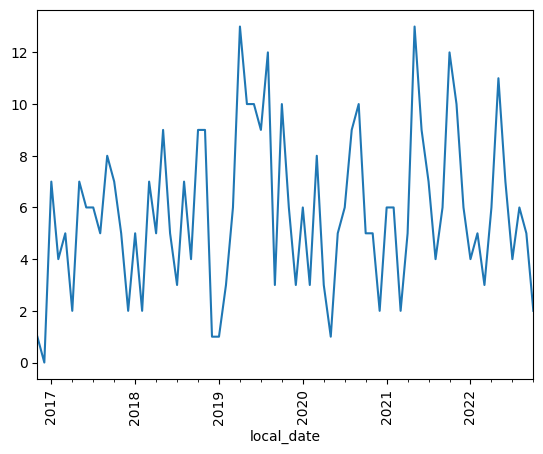

In [103]:
gps_disruption_df.resample('M', on='local_date').\
count()['Disruption Date/Time'].plot(rot=90)


## Analyse disruptions by location

### Add UK to two letter codes

In [104]:
two_letter_codes=\
pd.concat([two_letter_codes,\
           pd.DataFrame({'Code':"UK",'Subdivision name (en)':"United Kingdom",'Subdivision category':"Country",'clean_state':"UK"},index=[two_letter_codes['Code'].count()])])

### Add previous names to ISO list

In [105]:
sovereign_states['previous country name']=sovereign_states['Notes'].apply(lambda x: str(x).split('Previous ISO country name: ')[-1])

### Clean up Location to get country/code 

In [106]:
gps_disruption_df['location_clean']=gps_disruption_df['Location']#.apply(lambda x: x.upper())#\
#.replace('CYPRUS, LIMASSOL','LIMASSOL, CYPRUS').apply(lambda x:x.split(',')[-1].strip().split()[0])#.replace('WASHINGTON DC','DC')

#gps_disruption_df['location_clean2']=gps_disruption_df['Location'].apply(lambda x: x.upper())\
#.replace('CYPRUS, LIMASSOL','LIMASSOL, CYPRUS').apply(lambda x:x.split(',')[-1].strip())

In [107]:
#gps_disruption_df[
def token_search(x_string):
    #state_of_interest=None
    #country_of_interest=None
    for x_element in x_string.split():
        x_el_stripped=x_element.strip(',').strip(',')
        if x_el_stripped in list(two_letter_codes['clean_state' ]):
            state_of_interest=two_letter_codes[two_letter_codes['clean_state']==x_el_stripped]
            return list(state_of_interest['Subdivision name (en)'].to_dict().values())[0]
    for sovereign_state in list(sovereign_states['Country name (using title case)'].apply(lambda x:x.upper())):
        if sovereign_state in x_string.upper():
            return  sovereign_state
    for sovereign_state in list(sovereign_states['previous country name'].apply(lambda x:x.upper())):
        if sovereign_state in x_string.upper():
            return  sovereign_state
        #return state_of_interest,country_of_interest    
    #return state_of_interest,country_of_interest
gps_disruption_df['matched_location']=gps_disruption_df['location_clean'].apply(token_search)#=='LIMASSOL']


### Analyse per country and US state

<AxesSubplot: ylabel='matched_location'>

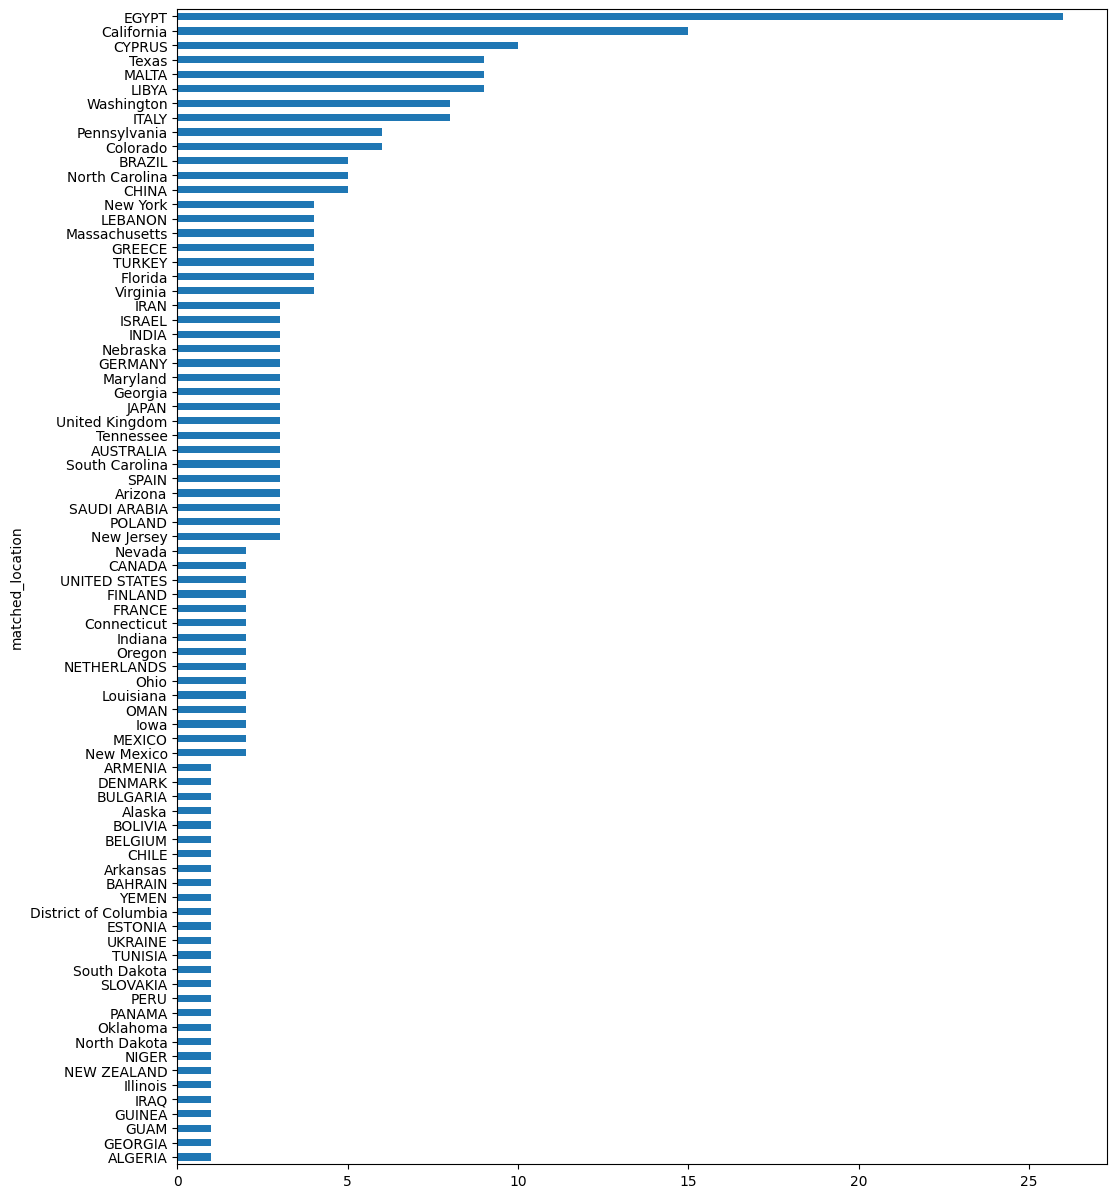

In [108]:
#.merge(two_letter_codes,how='left',left_on='location_clean',right_on='clean_state')\
gps_disruption_df[gps_disruption_df['matched_location'].notna()]\
.groupby('matched_location').count()['Disruption Date/Time'].sort_values()\
.plot(kind='barh',figsize=[12,15])

In [109]:
gps_disruption_df['matched_location'].dropna().unique()

array(['Texas', 'District of Columbia', 'South Carolina', 'CHINA',
       'GEORGIA', 'PANAMA', 'GUINEA', 'California', 'Massachusetts',
       'GREECE', 'Nevada', 'Nebraska', 'PERU', 'EGYPT', 'ESTONIA', 'IRAQ',
       'LIBYA', 'TURKEY', 'BELGIUM', 'ISRAEL', 'Oregon', 'Arkansas',
       'South Dakota', 'AUSTRALIA', 'BRAZIL', 'CYPRUS', 'MALTA',
       'North Dakota', 'POLAND', 'LEBANON', 'United Kingdom', 'ITALY',
       'TUNISIA', 'Virginia', 'Washington', 'GUAM', 'MEXICO', 'BAHRAIN',
       'INDIA', 'NETHERLANDS', 'Tennessee', 'Georgia', 'North Carolina',
       'New Mexico', 'Pennsylvania', 'Iowa', 'Florida', 'Illinois',
       'Colorado', 'SPAIN', 'Connecticut', 'SAUDI ARABIA', 'Maryland',
       'DENMARK', 'NEW ZEALAND', 'BOLIVIA', 'UKRAINE', 'Arizona', 'NIGER',
       'IRAN', 'OMAN', 'FINLAND', 'UNITED STATES', 'YEMEN', 'JAPAN',
       'Indiana', 'New York', 'SLOVAKIA', 'BULGARIA', 'Ohio', 'CANADA',
       'ARMENIA', 'GERMANY', 'Alaska', 'New Jersey', 'ALGERIA',
       'Oklahoma', 

In [110]:
gps_disruption_df[gps_disruption_df['matched_location']=='California']

,Disruption Date/Time,Location,Type,Description,Cause,Closed Date,User,NAVCEN,local_date,location_clean,matched_location
14,07/22/2022 11:30:00 PST,"Fontana, CA",Automobile,USER: Google maps and Garmin satellite recepti...,Insufficient Information,08/23/2022,USER: Google maps and Garmin satellite recepti...,: The GPS Operations Center reviewed the GPS C...,2022-07-22,"Fontana, CA",California
40,04/10/2022 13:37 PST,"San Diego, CA (Fasihion Valley Mall area",Automobile,USER: GPS on automobile was not working from a...,User Equipment,05/04/2022,USER: GPS on automobile was not working from a...,: Spoke to the reporting source and determined...,2022-04-10,"San Diego, CA (Fasihion Valley Mall area",California
69,10/28/2021 05:00 EST,"San Diego CA, Providence RI, Baton Rouge LA",Timing,USER: We have GPS clocks deployed across the U...,Other,02/09/2022,USER: We have GPS clocks deployed across the U...,: The GPS Operations Center reviewed the GPS C...,2021-10-28,"San Diego CA, Providence RI, Baton Rouge LA",California
112,05/14/2021 1400 PST,"Lompoc, CA",NaN,"USER: Was going to the beach, could not acquir...",Insufficient Information,05/27/2021,"USER: Was going to the beach, could not acquir...",: The GPS Operations Center reviewed the GPS C...,2021-05-14,"Lompoc, CA",California
144,11/15/2020 2300 PST,"Pacifica, CA",Marine,User: While conducting a search near Pacifica ...,Insufficient Information,12/15/2020,User: While conducting a search near Pacifica ...,: The GPS Operations Center reviewed the GPS C...,2020-11-15,"Pacifica, CA",California
201,01/01/2020 19:00 PST,"Lancaster CA, Hwy CA-14 crossing Ave J",Transportation,"User: This location, on CA-14 northbound cross...",Insufficient Information,07/30/2020,"User: This location, on CA-14 northbound cross...",: The GPS Operations Center reviewed the GPS C...,2020-01-01,"Lancaster CA, Hwy CA-14 crossing Ave J",California
255,05/30/2019 23:09 UTC,"Tokyo, Japan. Santa Rosa, CA",Timing,The receiver logged anomalous time of week bei...,User Equipment,09/11/2019,The receiver logged anomalous time of week bei...,: The GPS Operations Center reviewed the GPS C...,2019-05-30,"Tokyo, Japan. Santa Rosa, CA",California
256,05/23/2019 9:30 PST,"San Mateo, CA to Palo Alto, CA",Automobile,User: Both built-in and mobile phone GPS indic...,User Equipment,06/10/2019,User: Both built-in and mobile phone GPS indic...,: The GPS Operations Center reviewed the GPS C...,2019-05-23,"San Mateo, CA to Palo Alto, CA",California
258,05/17/2019 2030 UTC,"Lancaster, CA",Other,Synopsis: 4 [equipment] were powered on betwee...,User Equipment,06/03/2019,Synopsis: 4 [equipment] were powered on betwee...,: The GPS Operations Center reviewed the GPS C...,2019-05-17,"Lancaster, CA",California
261,05/14/2019 21:40 PST,"Hawthorne, CA",Law Enforcement,"User: For the past two days, our GPS receivers...",User Equipment,05/24/2019,"User: For the past two days, our GPS receivers...",: The GPS Operations Center reviewed the GPS C...,2019-05-14,"Hawthorne, CA",California


In [111]:
gps_disruption_df[gps_disruption_df['Location']=='Channel Islands, CA']['Description'].to_dict()

{401: 'User: Several systems, across all of our assets at sea, all affected NAVCEN: The GPS Operations Center reviewed the GPS Constellation and Control Segment, there are no known anomalies that might affect GPS signal integrity at the time and vicinity of the reported outage. Space Weather was reviewed and found unlikely to have impacted GPS performance. No correlating reports from other users or interagency partners. Authorized GPS testing was scheduled within 200 miles of the reported location and may have impacted GPS performance.'}

There is such a thing as https://en.wikipedia.org/wiki/Channel_Islands_(California)

### Unmatched location needs cleaning

In [112]:
disruptions_by_location=gps_disruption_df[gps_disruption_df['matched_location'].isna()].groupby('Location').count()['Disruption Date/Time']


In [113]:
disruptions_by_location[disruptions_by_location>1].sort_values(ascending=False)#.plot(kind='barh')

Location
Limassol                  6
Global                    4
East Mediterranean Sea    2
Eastern Mediterranean     2
Istanbul                  2
Mediterranean Sea         2
Shanghai, PRC             2
Suez Canal                2
Worldwide                 2
Name: Disruption Date/Time, dtype: int64

<AxesSubplot: ylabel='Location'>

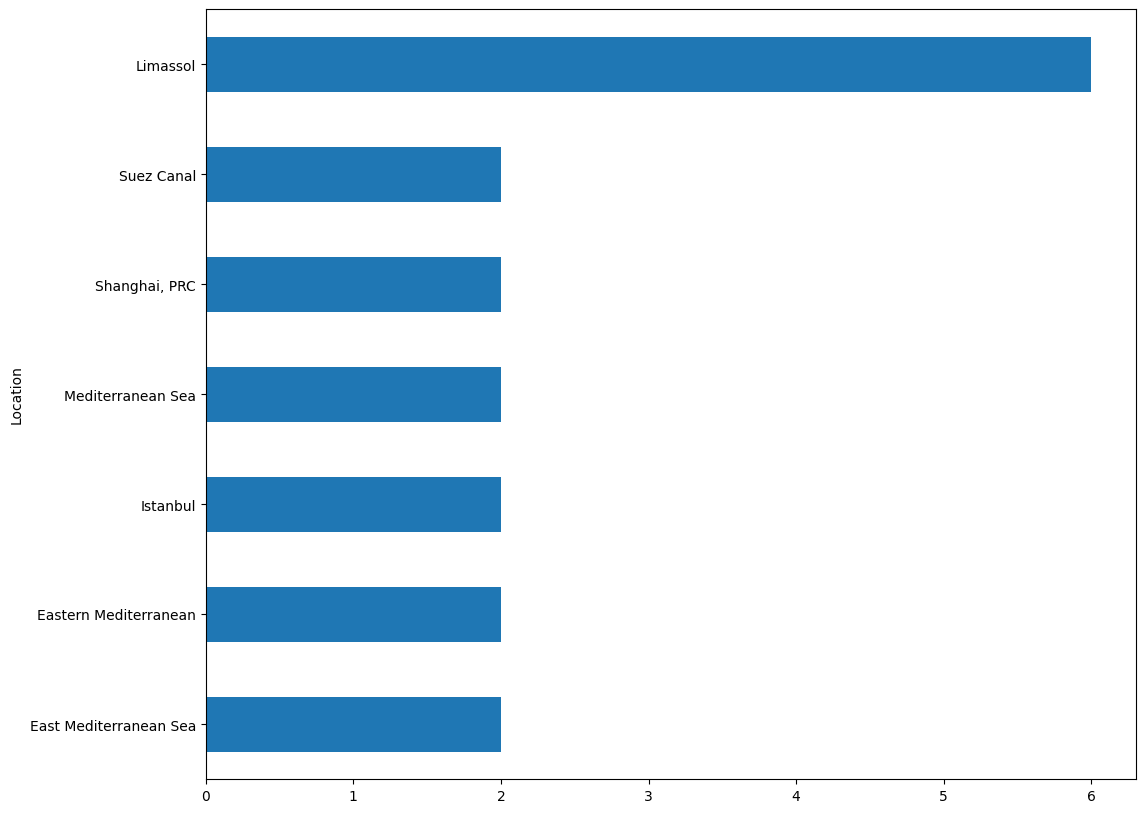

In [114]:
#def group_locations(string_x):
#    if string_x==''

disruptions_by_location[disruptions_by_location>1 ].drop(['Worldwide','Global']).sort_values()\
.plot(kind='barh',figsize=[12,10])

In [115]:
gps_disruption_df.query('Location in ("Worldwide","Global","At sea")')[['local_date','Location','Description','Cause']]

,local_date,Location,Description,Cause
91,2021-07-28,At sea,USER: The vessel was sailing towards port said...,Unknown Interference
138,2021-01-16,Global,CNES has detected a repetition of IODE for PRN...,IODC_10-Bit
169,2020-08-04,Global,User: CNES (Centre National d Etudes Spatiales...,ICD_Violation
195,2020-02-12,Worldwide,"User: In February 2020 (Feb 12th, 13th, 15th a...",ICD_Violation
286,2019-02-01,Global,User: Thanks to Navigation and Timing Monitori...,None
356,2017-11-30,Global,User: GPS PRN22 orbit error started to wander ...,User Equipment
372,2017-09-20,Worldwide,User: It appears that the Subframe-2 IODC mess...,User Equipment


In [116]:
for description_str in gps_disruption_df.query('Location=="United States"')['Description']:
    print(description_str)

At roughly 8:45 PM CST lost GPS Sync to various cell sites around the US. The common GPS is trend is dual cones feeding sync to UMTS and LTE technologies. To mitigate the issue Field Technicians have removed one of the GPS cones and have a master sync from LTE feeding UMTS. There was no back office or architectural changes to our network during this time that would have caused this failure. We are curious if there were any changes made in preparation of the GPS System rollover slated for tomorrow April 6th that may have affected the base stations to lose sync. NAVCEN: The U.S. Air Force points to Interface Specification IS-GPS-200, paragraph 20.3.3.5.2.2, Almanac Reference Time, which states: "The almanac reference time, t(oa), is some some multiple of 2(12) seconds occurring approximately 70 hours after the first valid transmission time for this almanac data set (reference 20.3.4.5). The almanac is updated often enough to ensure that GPS time, t, shall differ from t(oa) by less than 3

In [117]:
for description_str in gps_disruption_df.query('Location in ("Mediterranean Sea","Eastern Mediterranean","East Mediterranean Sea")')\
['Description']:
    print(description_str)

User indicated an intermittent problem that was otherwise unspecified. NAVCEN: The GPS Operations Center reviewed the GPS Constellation and Control Segment, there are no known anomalies that might affect GPS signal integrity at the time and vicinity of the reported problem. Space weather was reviewed and found unlikely to have impacted GPS performance. There were no authorized GPS tests in the area. No correlating reports from interagency partners. The report of interference is similar to that outlined by U.S. Maritime Administration in Maritime Advisory 2021-004-Various GPS Interference. User encouraged to report the issue to the nearest communication authority.
USER: roughly 12 hours of gps spoofing upon departure from port Said Egypt. GPS signal rapidly shifted numerous times, position 6-8 miles off. Position dropped for 90 percent of the 12 hours. GPS aboard connected to ECDIS, RADAR,AIS, GYRO repeater panel, GMDSS suite. NAVCEN: The GPS Operations Center reviewed the GPS Constella

### Rare locations

In [118]:
disruptions_by_location[disruptions_by_location==1 ]\
#.plot(kind='barh',figsize=[12,10])
#.drop(['AK','SD','OK','NM','DC','ND'])

Location
100NM off Port Said                     1
35 - 04.4N, 034 - 48.1E                 1
AT SEA                                  1
Abu Musa Island                         1
Albany, New York                        1
                                       ..
sikeston                                1
tehran                                  1
toledo, ohio                            1
transiting inside Suez Canal N-bound    1
Харьков                                 1
Name: Disruption Date/Time, Length: 137, dtype: int64

### quantify scale of each subgroup

In [119]:
gps_disruption_df['matched_location'].nunique()

80

In [120]:
gps_disruption_df[gps_disruption_df['matched_location'].notna()]['Disruption Date/Time'].count()

258

In [121]:
disruptions_by_location[disruptions_by_location>1 ].count()

9

In [122]:
disruptions_by_location[disruptions_by_location==1 ].count()

137